# Analyzing CyclePronto Data with Python & Pandas

This week, Seattle's Bicycle Share provider [Pronto CycleShare](https://www.prontocycleshare.com/), turned one year old.
To celebrate this, Pronto made available a large cache of data from the first year of operation and announced the [Pronto Cycle Share's Data Challenge](http://www.prontocycleshare.com/datachallenge), which offers prizes for different types of analysis.

In this post, I want to show how you can get started analyzing this data (and joining it with other available data sources) using the PyData stack, including NumPy, Pandas, Matplotlib, and Seaborn.
We'll take a look at some of the basic questions you can answer with this data.
Later I plan to dig deeper and ask some more interesting and creative questions.

This post is composed in the form of a [Jupyter Notebook](https://jupyter.org/), which is an open document format that combines text, code, data, and graphics and is viewable through the web browser – if you have not used it before I encourage you to try it out!
You can download the raw notebook [here](), run it in Jupyter, and strt asking your own questions.

## Downloading Pronto's Data

We'll start by downloading the data (available on [Pronto's Website](http://www.prontocycleshare.com/datachallenge)) which you can do by uncommenting the following shell commands (the exclamation mark here is a special IPython syntax to run a shell command).
The total download is about 70MB, and the unzipped files are around 900MB.

In [1]:
# !curl -O https://s3.amazonaws.com/pronto-data/open_data_year_one.zip
# !unzip open_data_year_one.zip

Next we need some standard Python package imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

And now we load the trip data with Pandas:

In [3]:
trips = pd.read_csv('2015_trip_data.csv',
                    parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True)
trips.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971


Each row of this trip dataset is a single ride by a single person, and the data contains over 140,000 rows!

## Exploring Trips over Time

Let's start by looking at the trend in number of daily trips over the course of the year

In [4]:
# Find the start date
trips['date'] = trips.starttime.map(pd.Timestamp.date).astype('datetime64')

In [5]:
# Count trips by date
by_date = trips.pivot_table('trip_id', aggfunc='count',
                            index='date',
                            columns='usertype', )

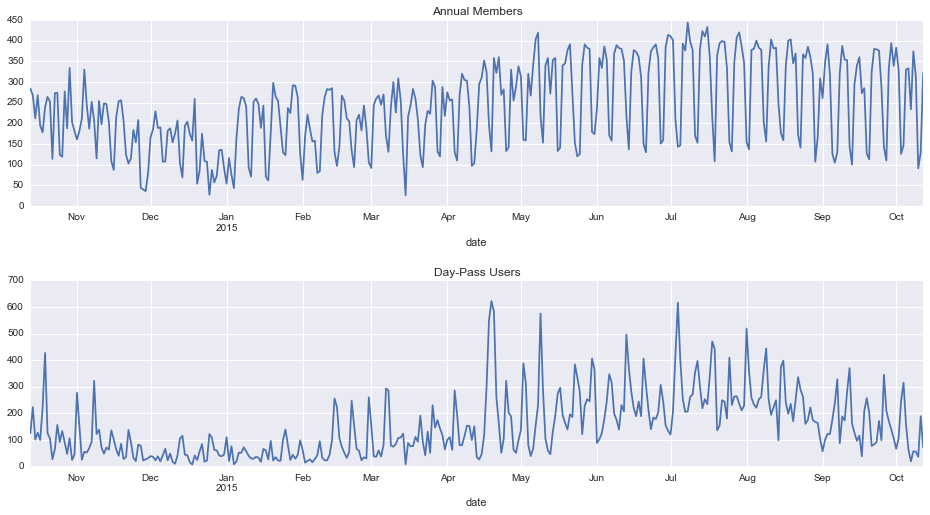

In [6]:
fig, ax = plt.subplots(2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.4)
by_date.iloc[:, 0].plot(ax=ax[0], title='Annual Members');
by_date.iloc[:, 1].plot(ax=ax[1], title='Day-Pass Users');

This plot shows the daily trend, separated by Annual members (top) and Day-Pass users (bottom).
A couple observations:

- The big spike in short-term pass rides in April is likely due to the [American Planning Association national conference](http://www.planetizen.com/node/75958/seattle-sets-bikeshare-record-apa-town), held in downtown Seattle that week. The only other time that gets close is the 4th of July weekend.
- Day pass users seem to show a steady ebb and flow with the seasons; the usage of annual users has not waned as significantly with the coming of fall.
- Both annual members and day-pass users seem to show a distinct weekly trend.

Let's zoom-in on this weekly trend, by averaging all rides by day of week.
Becuase of the change in pattern around January 2015, we'll split the data by both year and by day of week:

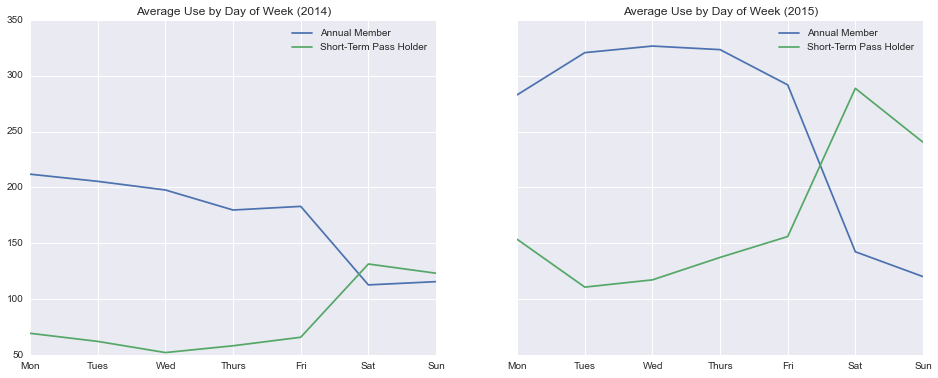

In [7]:
by_weekday = by_date.groupby([by_date.index.year, by_date.index.dayofweek]).mean()
by_weekday.columns.name = None

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
by_weekday.loc[2014].plot(title='Average Use by Day of Week (2014)', ax=ax[0]);
by_weekday.loc[2015].plot(title='Average Use by Day of Week (2015)', ax=ax[1]);
for axi in ax:
    axi.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

We see a complementary pattern overall: annual users tend to use their bikes during Monday to Friday (i.e. as part of a commute) while day pass users tend to use their bikes on the weekend.
This pattern didn't fully develop until the start of 2015, however, especially for annual members: it seems that for the first couple months, users had not yet adapted their commute habits to make use of Pronto!

It's also quite interesting to view the average hourly trips by weekday and weekend.
This takes a bit of manipulation:

In [8]:
# get counts by day and by hour
by_datehour = trips.pivot_table('trip_id', aggfunc='count',
                               index=[pd.DatetimeIndex(trips.starttime).date,
                                      pd.DatetimeIndex(trips.starttime).hour],
                               columns='usertype').fillna(0).reset_index()
by_datehour = by_datehour.rename(columns={'level_0':'date', 'level_1':'hour'})

In [9]:
# average these counts by weekday and weekend
weekend = pd.DatetimeIndex(by_datehour.date).dayofweek >= 5
by_hour = by_datehour.groupby([weekend, 'hour']).mean()

by_hour.index.set_levels([[False, True],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);

Let's plot these now:

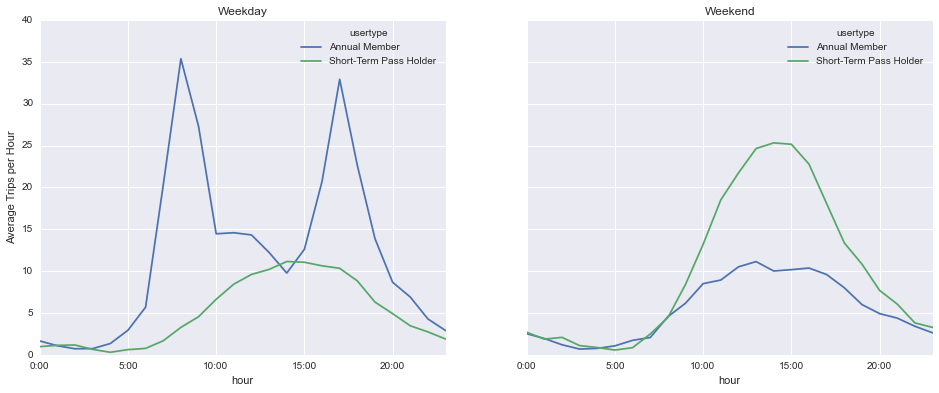

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

by_hour.loc[False].plot(title='Weekday', ax=ax[0])
by_hour.loc[True].plot(title='Weekend', ax=ax[1])
ax[0].set_ylabel('Average Trips per Hour');

We see a clear difference between a "commute" pattern, which sharply peaks in the morning and evening (e.g. annual members during weekdays) and a "recreational" pattern, which has a broad peak in the early afternoon (e.g. annual members on weekends, and short-term users all the time).
For those who have read my previous posts, you might recognize this as very similar to the patterns I found in the [Fremont Bridge](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) bicycle counts.

## Trip Durations

Next let's take a look at the durations of trips.
Pronto rides are designed to be up to 30 minutes; longer than this [incurs a usage fee](https://www.prontocycleshare.com/pricing) of a couple dollars for the first half hour, and about ten dollars per hour thereafter.

Let's look at the distribution of trip durations for Annual members and short-term pass holders:

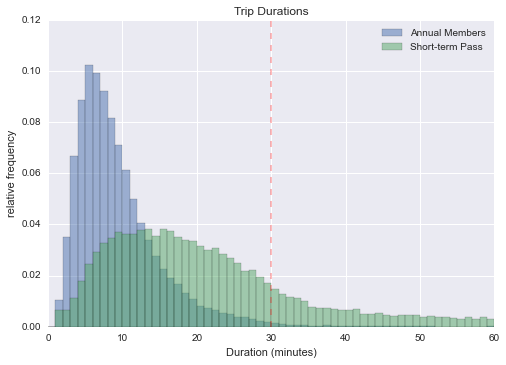

In [11]:
trips['minutes'] = trips.tripduration / 60
trips.groupby('usertype')['minutes'].hist(bins=np.arange(61), alpha=0.5, normed=True);
plt.xlabel('Duration (minutes)')
plt.ylabel('relative frequency')
plt.title('Trip Durations')
plt.legend(['Annual Members', 'Short-term Pass'])

plt.axvline(30, linestyle='--', color='red', alpha=0.3);

It seems that annual users are much more savvy to the system rules: only a small tail of the trip distribution lies beyond 30 minutes.
Around one in four Day Pass Rides, on the other hand, are longer than the half hour limit and incur additional fees.
My hunch is that these day pass users aren't fully aware of this pricing structure ("I paid for the day, right?") and walk away unhappy with the situation.

## Estimating Trip Distances

It's also interesting to look at the distance of the trips.
Distances between stations are not included in Pronto's data release, so we need to find them via another source.
Let's start by loading the station data – and because some of the trips start and end at Pronto's shop, we'll add this as another "station":

In [12]:
stations = pd.read_csv('2015_station_data.csv')
pronto_shop = dict(id=54, name="Pronto shop",
                   terminal="Pronto shop",
                   lat=47.6173156, long=-122.3414776,
                   dockcount=100, online='10/13/2014')
stations = stations.append(pronto_shop, ignore_index=True)
stations.head()

,id,name,terminal,lat,long,dockcount,online
0,1,3rd Ave & Broad St,BT-01,47.618418,-122.350964,18,10/13/2014
1,2,2nd Ave & Vine St,BT-03,47.615829,-122.348564,16,10/13/2014
2,3,6th Ave & Blanchard St,BT-04,47.616094,-122.341102,16,10/13/2014
3,4,2nd Ave & Blanchard St,BT-05,47.613110,-122.344208,14,10/13/2014
4,5,2nd Ave & Pine St,CBD-13,47.610185,-122.339641,18,10/13/2014


Now we need to find bicycling distances between pairs of lat/lon coordinates.
Fortunately, Google Maps has an API that we can use for free:

https://developers.google.com/maps/documentation/distance-matrix/intro

Reading the fine print, free use is limited to 2500 distances per day, and 100 distances per 10 seconds.
With 55 stations we have $55 \times 54 / 2 = 1485$ unique nonzero distances, so we can just query all of them within a few minutes on a single day for free (if we do it carefully).

To do this, we'll query one (partial) row at a time, waiting 10+ seconds between queries (Note: we might also use the [googlemaps Python package](https://github.com/googlemaps/google-maps-services-python) instead, but it requires an API key).

In [13]:
from time import sleep

def query_distances(stations=stations):
    """Query the Google API for bicycling distances"""
    latlon_list = ['{0},{1}'.format(lat, long)
                   for (lat, long) in zip(stations.lat, stations.long)]

    def create_url(i):
        URL = ('https://maps.googleapis.com/maps/api/distancematrix/json?'
               'origins={origins}&destinations={destinations}&mode=bicycling')
        return URL.format(origins=latlon_list[i],
                          destinations='|'.join(latlon_list[i + 1:]))

    for i in range(len(latlon_list) - 1):
        url = create_url(i)
        filename = "distances_{0}.json".format(stations.terminal.iloc[i])
        print(i, filename)
        !curl "{url}" -o {filename}
        sleep(11) # only one query per 10 seconds!


def build_distance_matrix(stations=stations):
    """Build a matrix from the Google API results"""
    dist = np.zeros((len(stations), len(stations)), dtype=float)
    for i, term in enumerate(stations.terminal[:-1]):
        filename = 'queried_distances/distances_{0}.json'.format(term)
        row = json.load(open(filename))
        dist[i, i + 1:] = [el['distance']['value'] for el in row['rows'][0]['elements']]
    dist += dist.T
    distances = pd.DataFrame(dist, index=stations.terminal,
                             columns=stations.terminal)
    distances.to_csv('station_distances.csv')
    return distances

# only call this the first time
import os
if not os.path.exists('station_distances.csv'):
    # Note: you can call this function at most ~twice per day!
    query_distances()

    # Move all the queried files into a directory
    # so we don't accidentally overwrite them
    if not os.path.exists('queried_distances'):
        os.makedirs('queried_distances')
    !mv distances_*.json queried_distances

    # Build distance matrix and save to CSV
    distances = build_distance_matrix()

Here's what the first 5x5 section of the distance matrix looks like:

In [14]:
distances = pd.read_csv('station_distances.csv', index_col='terminal')
distances.iloc[:5, :5]

,BT-01,BT-03,BT-04,BT-05,CBD-13
terminal,,,,,
BT-01,0,422,1067,867,1342
BT-03,422,0,838,445,920
BT-04,1067,838,0,1094,1121
BT-05,867,445,1094,0,475
CBD-13,1342,920,1121,475,0


The distances here are reported are in meters: we'll convert these to miles.
Finally, we can now join this distance data to our trips data:

In [15]:
stacked = distances.stack() / 1609.34  # convert meters to miles
stacked.name = 'distance'
trips = trips.join(stacked, on=['from_station_id', 'to_station_id'])

Let's see the distribution of distances:

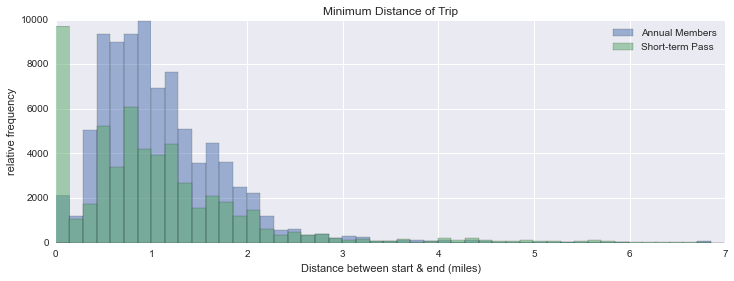

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
trips.groupby('usertype')['distance'].hist(bins=np.linspace(0, 6.99, 50),
                                           alpha=0.5, ax=ax);
plt.xlabel('Distance between start & end (miles)')
plt.ylabel('relative frequency')
plt.title('Minimum Distance of Trip')
plt.legend(['Annual Members', 'Short-term Pass']);

This shows the shortest possible distance between stations, and thus is a **lower bound** on the actual distance ridden on each trip.
Many trips (especially for day pass users) begin and end within a few blocks.
Beyond this, trips peak at around 1 mile, though some extreme users are pushing their trips out to four or more miles.

## Estimating Rider Speed

Given these distances, we can also compute a lower bound on the estimated riding speed.
Let's do this, and then show the distribution of speeds for Annual and Short-term users:

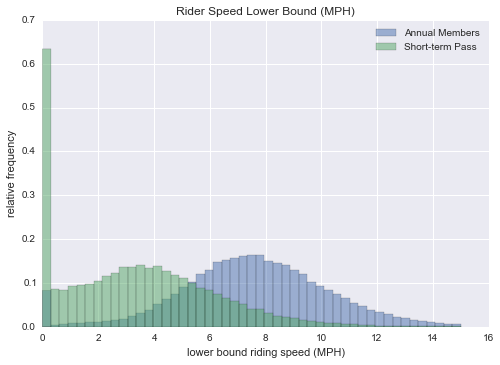

In [17]:
trips['speed'] = trips.distance * 60 / trips.minutes
trips.groupby('usertype')['speed'].hist(bins=np.linspace(0, 15, 50), alpha=0.5, normed=True);
plt.xlabel('lower bound riding speed (MPH)')
plt.ylabel('relative frequency')
plt.title('Rider Speed Lower Bound (MPH)')
plt.legend(['Annual Members', 'Short-term Pass']);

Interestingly, the distributions are quite different, with annual riders showing on average a higher inferred speed.
You might be tempted to conclude here that annual members ride faster than day-pass users, but the data alone aren't sufficient to support this conclusion.
This data could also be explained if annual users tend to go from point A to point B by the most direct route, while day pass users tend to meander around and get to their destination indirectly.
I suspect that the reality is some mix of these two effects.

For the annual riders, the distribution looks very much like a classic bell curve, and we can compute the mean and standard deviation:

In [18]:
speed = trips.query('usertype == "Annual Member" & speed > 0').speed
print("avg speed = {0:.1f} +/- {1:.1f}".format(speed.mean(), speed.std()))

avg speed = 7.8 +/- 2.7


Annual riders (assuming they tend to take the shortest route) ride at just under 8 miles per hour, with a standard deviation of 2.7.

It is also informative to take a look at the relationship between distance and speed:

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


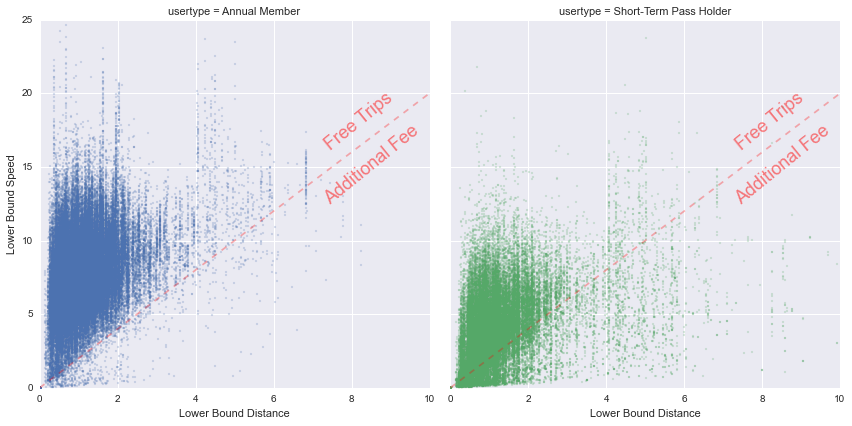

In [19]:
g = sns.FacetGrid(trips, col="usertype", hue='usertype', size=6)
g.map(plt.scatter, "distance", "speed", s=4, alpha=0.2)

# Add lines and labels
x = np.linspace(0, 10)
g.axes[0, 0].set_ylabel('Lower Bound Speed')
for ax in g.axes.flat:
    ax.set_xlabel('Lower Bound Distance')
    ax.plot(x, 2 * x, '--r', alpha=0.3)
    ax.text(9.8, 16.5, "Free Trips\n\nAdditional Fee", ha='right',
            size=18, rotation=39, alpha=0.5, color='red')
    ax.axis([0, 10, 0, 25])

Overall, we see that longer rides tend to be faster – though this is subject to the same lower-bound caveats as above.
For reference above, I have plotted the line separating free trips (above the red line) from trips requiring an additional fee (below the red line).
Again we see that the annual members are much more savvy about not going over the half hour limit than are day pass users.

## Trend with Elevation

One oft-mentioned concern with the feasibility of bike share in Seattle is that it is a very hilly city – before the launch, armchair analysts predicted that there would be a steady flow of bikes from uphill to downhill, and that this would add up with other challenges to spell the demise of the system ("Sure, bikeshare works other places, but it can't work here: Seattle is *special*! We're just *so special*!")

Elevation data is not included in the data release, but again we can turn to the Google Maps API to get what we need; information is here: https://developers.google.com/maps/documentation/elevation/intro

In this case the free-use limit is 2500 requests per day & 512 elevations per request.
Since we only need 50 elevations, we can do it in a single query:

In [20]:
def get_station_elevations(stations):
    """Get station elevations via Google Maps API"""
    URL = "https://maps.googleapis.com/maps/api/elevation/json?locations="
    locs = '|'.join(['{0},{1}'.format(lat, long)
                     for (lat, long) in zip(stations.lat, stations.long)])
    URL += locs
    !curl "{URL}" -o elevations.json


def process_station_elevations():
    """Convert Elevations JSON output to CSV"""
    import json
    D = json.load(open('elevations.json'))
    def unnest(D):
        loc = D.pop('location')
        loc.update(D)
        return loc
    elevs = pd.DataFrame([unnest(item) for item in D['results']])
    elevs.to_csv('station_elevations.csv')
    return elevs

# only run this the first time:
import os
if not os.path.exists('station_elevations.csv'):
    get_station_elevations(stations)
    process_station_elevations()

Now let's read-in the elevation data:

In [21]:
elevs = pd.read_csv('station_elevations.csv', index_col=0)
elevs.head()

,elevation,lat,lng,resolution
0,37.351780,47.618418,-122.350964,76.351616
1,33.815830,47.615829,-122.348564,76.351616
2,34.274055,47.616094,-122.341102,76.351616
3,44.283257,47.613110,-122.344208,76.351616
4,42.460381,47.610185,-122.339641,76.351616


Just to make ourselves feel better, we'll double check that the latitudes and longitudes match:

In [22]:
# double check that locations match
print(np.allclose(stations.long, elevs.lng))
print(np.allclose(stations.lat, elevs.lat))

True
True


Now we can join the elevations to with the trip data by way of the station data:

In [23]:
stations['elevation'] = elevs['elevation']
elevs.index = stations['terminal']

trips['elevation_start'] = trips.join(elevs, on='from_station_id')['elevation']
trips['elevation_end'] = trips.join(elevs, on='to_station_id')['elevation']
trips['elevation_gain'] = trips['elevation_end'] - trips['elevation_start']

Let's take a look at the distribution of elevation gain by rider type:

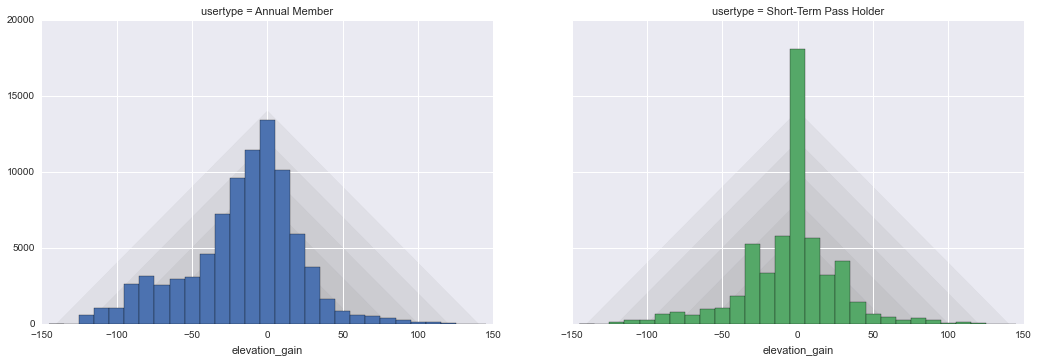

In [24]:
g = sns.FacetGrid(trips, col="usertype", hue='usertype')
g.map(plt.hist, "elevation_gain", bins=np.arange(-145, 150, 10))
g.fig.set_figheight(6)
g.fig.set_figwidth(16);

# plot some lines to guide the eye
for lim in range(60, 150, 20):
    x = np.linspace(-lim, lim, 3)
    for ax in g.axes.flat:
        ax.fill(x, 100 * (lim - abs(x)),
                color='gray', alpha=0.1, zorder=0)

We have plotted some shading in the background to help guide the eye.
Again, there is a big difference between Annual Members and Short-term users: annual users definitely show a preference for downhill trips (left of the distribution), while daily users dont show this as strongly (and also have a lot of rides with zero gain).

To make this more concrete, let's compute the numbers:

In [25]:
print("total downhill trips:", (trips.elevation_gain < 0).sum())
print("total uphill trips:  ", (trips.elevation_gain > 0).sum())

total downhill trips: 80532
total uphill trips:   50493


We see that there are about 60% more uphill trips than downhill trips, which means given current usage levels that Pronto staff must be shuttling an average of about 100 bikes per day from low-lying stations to higher-up stations.

## Weather

The other common "Seattle is special" argument against the feasibility of cycle share is the weather.
Let's take a look at how the weather affects rides.
The data release includes a wide range of weather data:

In [26]:
weather = pd.read_csv('2015_weather_data.csv', index_col='Date', parse_dates=True)
weather.columns

Index(['Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF',
       'Max_Dew_Point_F', 'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity',
       'Mean_Humidity ', 'Min_Humidity ', 'Max_Sea_Level_Pressure_In ',
       'Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In ',
       'Max_Visibility_Miles ', 'Mean_Visibility_Miles ',
       'Min_Visibility_Miles ', 'Max_Wind_Speed_MPH ', 'Mean_Wind_Speed_MPH ',
       'Max_Gust_Speed_MPH', 'Precipitation_In ', 'Events'],
      dtype='object')

Let's join this weather data with the trip data:

In [27]:
by_date = trips.groupby(['date', 'usertype'])['trip_id'].count()
by_date.name = 'count'
by_date = by_date.reset_index('usertype').join(weather)

Let's take a look at how the number of rides scales with both Temperature and Precipitation, splitting the data by weekday and weekend:

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


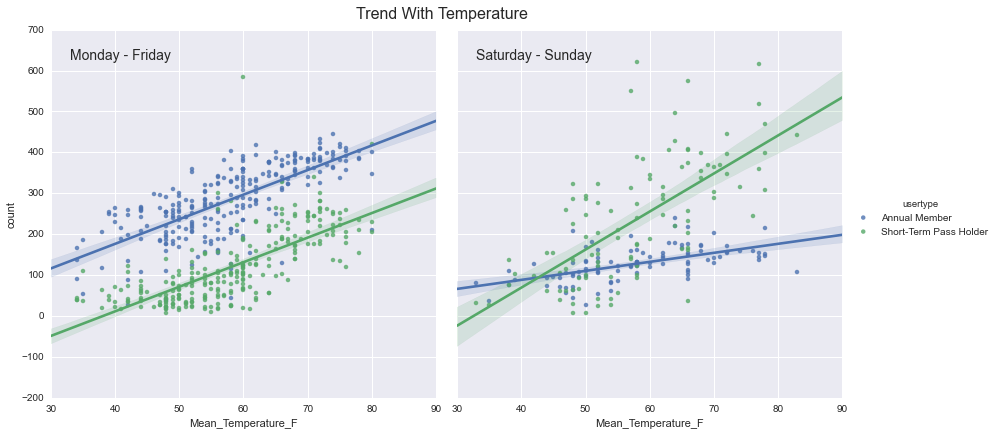

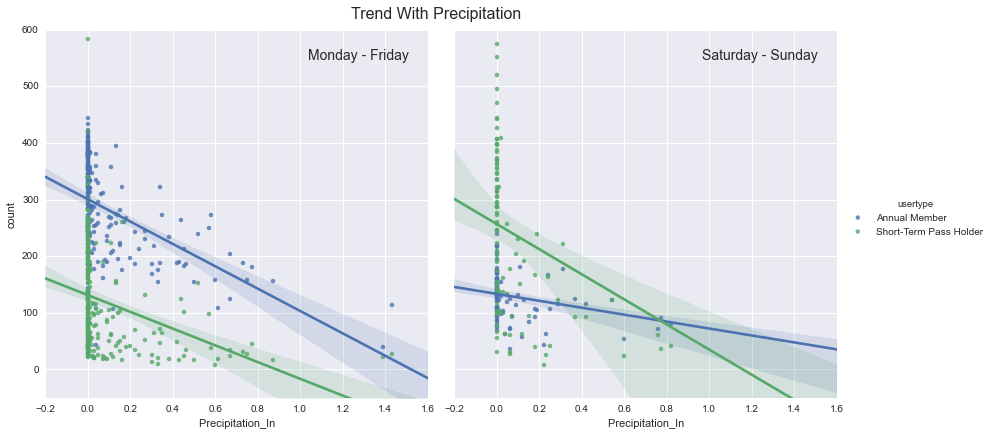

In [28]:
# add a flag indicating weekend
by_date['weekend'] = (by_date.index.dayofweek >= 5)

# Plot Temperature Trend
g = sns.FacetGrid(by_date, col="weekend", hue='usertype', size=6)
g.map(sns.regplot, "Mean_Temperature_F", "count")
g.add_legend();

# do some formatting
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.95, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.95, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Trend With Temperature", ha='center', va='top', size=16);

# Plot Precipitation
g = sns.FacetGrid(by_date, col="weekend", hue='usertype', size=6)
g.map(sns.regplot, "Precipitation_In ", "count")
g.add_legend();

# do some formatting
g.axes[0, 0].set_ylim(-50, 600);
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.95, 0.95, 'Monday - Friday', ha='right', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.95, 0.95, 'Saturday - Sunday', ha='right', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Trend With Precipitation", ha='center', va='top', size=16);

For both temperature and precipitiation, we see trends in the direction we might expect (people ride more on warm, sunny days).
But there are some interesting details: *during the work week*, Annual and Short-term users are equally affected by the weather.
On the weekend, however, annual members appear **less** influenced by weather, while short-term users appear **more** influenced.
I'm not entirely sure how to explain that trend.